In [ ]:
!pip install -q split-folders

In [ ]:
import os
import time
from tqdm.notebook import tqdm

# download data
import cv2
from PIL import Image
from pathlib import Path
import splitfolders

# from efficientnet_pytorch import EfficientNet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms, datapoints
from torchvision.datasets import ImageFolder
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.v2 import functional as FT
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [ ]:
from tensorflow import keras

In [ ]:
# Проверим доступность GPU на CUDA
torch.cuda.is_available()
use_gpu = torch.cuda.is_available()
use_gpu

True

In [ ]:
# Добавим cuda на девайс
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [ ]:
# celeba images 0-30k archive
!gdown 1MIA99QUIxXvaBFOZFbVsVoYJPL-6_FzN -O /content/celeba/

Downloading...
From: https://drive.google.com/uc?id=1MIA99QUIxXvaBFOZFbVsVoYJPL-6_FzN
To: /content/celeba/0-30k.zip
100% 1.56G/1.56G [00:24<00:00, 64.1MB/s]


In [ ]:
# identity person
!gdown 1ZEKVXe54rFwI2vPgCKDGE-d0BJWZ2NDp -O /content/celeba/

Downloading...
From: https://drive.google.com/uc?id=1ZEKVXe54rFwI2vPgCKDGE-d0BJWZ2NDp
To: /content/celeba/identity_CelebA.txt
100% 3.42M/3.42M [00:00<00:00, 237MB/s]


In [ ]:
# image attributes
!gdown 1Upj8NyGp7nGoslEuQHirfjYFHA37PJCa -O /content/celeba/

Downloading...
From: https://drive.google.com/uc?id=1Upj8NyGp7nGoslEuQHirfjYFHA37PJCa
To: /content/celeba/list_attr_celeba.txt
100% 26.7M/26.7M [00:00<00:00, 66.7MB/s]


In [ ]:
# image bbox
!gdown 1Tvpz-ZHeYpwhe16_QJwUCjY416d9z-ar -O /content/celeba/

Downloading...
From: https://drive.google.com/uc?id=1Tvpz-ZHeYpwhe16_QJwUCjY416d9z-ar
To: /content/celeba/list_bbox_celeba.txt
100% 6.08M/6.08M [00:00<00:00, 62.2MB/s]


In [ ]:
mkdir -p /content/celeba/images/0_30k/

In [ ]:
!unzip /content/celeba/0-30k.zip  -d /content/celeba/images/0_30k/ &>/dev/null

In [ ]:
ROOT = "/content/celeba/images/0_30k/"
ALL_IMAGES = list(Path(ROOT).glob("**/*.jpg"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))
print("Number of images:", len(ALL_IMAGES))

Number of images: 30000


In [ ]:
INPUT_PATH = '/content/celeba/images/'
SPLIT_PATH = '/content/celeba/split'


splitfolders.ratio(
                    INPUT_PATH,
                    SPLIT_PATH,
                    seed=42,
                    ratio=(.4, .2, .4),
                    group_prefix=None,
                    move=False
)

In [ ]:
batch_size=16

transform_train = transforms.Compose(
                [
                 transforms.Resize((500, 350)),
                 # transforms.RandomHorizontalFlip(p=.5),
                 # transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                 ]
)


transform_val = transforms.Compose(
                [
                 transforms.Resize((500, 350)),
                 # transforms.RandomHorizontalFlip(p=.5),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                 ]
)


TRAIN_PATH = SPLIT_PATH / Path("train")
VAL_PATH = SPLIT_PATH / Path("val")
TEST_PATH = SPLIT_PATH / Path("test")

train_ds = ImageFolder(TRAIN_PATH, transform_train)
val_ds = ImageFolder(VAL_PATH, transform_val)
test_ds = ImageFolder(TEST_PATH, transform_val)

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
label_names = FasterRCNN_ResNet50_FPN_Weights.COCO_V1.meta["categories"]
label_names[:3]

['__background__', 'person', 'bicycle']

In [ ]:
def inv_transforms(img):
  inv_transforms = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
  return inv_transforms(img)

In [ ]:
def get_label_names(labels, label_names):
  labels = labels.cpu().tolist()
  return [label_names[x] for x in labels]

In [ ]:
def show_preds(image, prediction=None, threshold=None):
  if prediction is not None and threshold is not None:
    img = inv_transforms(image)
    img = FT.convert_dtype(img, torch.uint8)
    boxes = prediction['boxes'][prediction['scores'] > CONF_THRESH]
    label = prediction['labels'][prediction['scores'] > CONF_THRESH]
  elif prediction is not None and threshold is None:
    img = inv_transforms(image)
    img = FT.convert_dtype(img, torch.uint8)
    boxes = prediction
    label = torch.tensor([1])
  else:
    img = inv_transforms(image[0])
    img = FT.convert_dtype(img, torch.uint8)
    boxes = image[1]['boxes']
    label = image[1]['labels']
  label = get_label_names(label, label_names)
  annotated_image = draw_bounding_boxes(img, boxes, labels=label, colors="red", width=1)
  fig, ax = plt.subplots()
  ax.imshow(annotated_image.permute(1, 2, 0).cpu().numpy())
  ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
  fig.tight_layout()
  fig.show()

In [ ]:
bbox_celeba = pd.read_csv('/content/celeba/list_bbox_celeba.txt', delim_whitespace=True, header=1)
bbox_celeba.head()
# x_1 and y_1 represent the upper left point coordinate of bounding box.
bbox_celeba.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


In [ ]:
bbox_celeba['x_2'] =  bbox_celeba['x_1'] + bbox_celeba['width']
bbox_celeba['y_2'] =  bbox_celeba['y_1'] + bbox_celeba['height']
bbox_celeba = bbox_celeba.drop(['width', 'height'], axis=1)
all_bboxes = bbox_celeba.to_numpy()
all_bboxes

array([['000001.jpg', 95, 71, 321, 384],
       ['000002.jpg', 72, 94, 293, 400],
       ['000003.jpg', 216, 59, 307, 185],
       ...,
       ['202597.jpg', 53, 76, 144, 202],
       ['202598.jpg', 195, 28, 286, 154],
       ['202599.jpg', 101, 101, 280, 349]], dtype=object)

In [ ]:
image_names = sorted(os.listdir(TRAIN_PATH / Path("0_30k")))
image_names[:3]

['000001.jpg', '000008.jpg', '000011.jpg']

In [ ]:
val_image_names = sorted(os.listdir(VAL_PATH / Path("0_30k")))
val_image_names[:3]

['000002.jpg', '000005.jpg', '000009.jpg']

In [ ]:
train_bboxes = []
for i in image_names:
  train_bboxes.append(all_bboxes[:, 1:][np.where(all_bboxes[:, 0] == i)].reshape(-1).tolist())
train_bboxes[:3]

[[95, 71, 321, 384], [212, 89, 430, 391], [166, 68, 291, 241]]

In [ ]:
len(train_bboxes)

12000

In [ ]:
val_bboxes = []
for i in val_image_names:
  val_bboxes.append(all_bboxes[:, 1:][np.where(all_bboxes[:, 0] == i)].reshape(-1).tolist())
val_bboxes[:3]

[[72, 94, 293, 400], [236, 109, 356, 275], [600, 274, 943, 749]]

In [ ]:
len(val_bboxes)

6000

In [ ]:
class CreateDatasetBoxes(torch.utils.data.Dataset):
    def __init__(self, root, transform, bboxes, resize_size=None):
        self.root = root
        self.transforms = transform
        self.bboxes = bboxes
        self.imgs = list(sorted(os.listdir(os.path.join(root, "0_30k"))))
        if resize_size is not None:
          self.resize = transforms.v2.Resize(resize_size)
        else:
          self.resize = None


    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "0_30k", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        # too slow for each try
        '''
        mask = np.isin(element=self.bboxes[:, 0], test_elements=self.image_names)
        selected_bboxes = self.bboxes[mask, 1:].astype(dtype=float)


        selected_bboxes = []
        for i in self.image_names:
          selected_bboxes.append(self.bboxes[:, 1:][np.where(self.bboxes[:, 0] == i)].reshape(-1).tolist())

        selected_bboxes = np.asarray(selected_bboxes).astype(dtype=float)
        '''


        torch_bbox = datapoints.BoundingBox(
            self.bboxes[idx],
            format=datapoints.BoundingBoxFormat.XYXY,
            spatial_size=img.size[::-1]
            )

        if self.resize is not None:
          img = self.resize(img)
          bboxes = self.resize(torch_bbox)

        labels = torch.ones((1), dtype=torch.int64)
        bboxes = torch.as_tensor(bboxes, dtype=torch.int64)
        bboxes = bboxes.unsqueeze(0)
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((1), dtype=torch.int64)

        target = {}
        target["boxes"] = bboxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd


        if self.transforms is not None:
          img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
transform_images = transforms.Compose(
                [
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                 ]
)

In [ ]:
ds_celeba_train = CreateDatasetBoxes(TRAIN_PATH, transform_images, train_bboxes, (500, 350))
ds_celeba_train[0]

(tensor([[[2.2147, 2.2147, 2.2147,  ..., 2.2318, 2.2318, 2.2318],
          [2.2147, 2.2147, 2.2147,  ..., 2.2318, 2.2318, 2.2318],
          [2.2147, 2.2147, 2.2147,  ..., 2.2318, 2.2318, 2.2318],
          ...,
          [2.2147, 2.2147, 2.2147,  ..., 2.0777, 1.9749, 2.0092],
          [2.2147, 2.2147, 2.2147,  ..., 2.1633, 1.9749, 1.9578],
          [2.2147, 2.2147, 2.2147,  ..., 2.2318, 2.0605, 1.9749]],
 
         [[2.0084, 2.0084, 2.0084,  ..., 2.2360, 2.2360, 2.2360],
          [2.0084, 2.0084, 2.0084,  ..., 2.2360, 2.2360, 2.2360],
          [2.0084, 2.0084, 2.0084,  ..., 2.2360, 2.2360, 2.2360],
          ...,
          [1.7808, 1.7808, 1.7808,  ..., 0.9755, 0.9930, 1.1155],
          [1.7808, 1.7808, 1.7808,  ..., 1.0455, 0.9930, 1.0455],
          [1.7808, 1.7808, 1.7808,  ..., 1.1331, 1.0805, 1.0805]],
 
         [[1.5420, 1.5420, 1.5420,  ..., 2.0125, 2.0125, 2.0125],
          [1.5420, 1.5420, 1.5420,  ..., 2.0125, 2.0125, 2.0125],
          [1.5420, 1.5420, 1.5420,  ...,

In [ ]:
ds_celeba_val = CreateDatasetBoxes(VAL_PATH, transform_images, val_bboxes, (500, 350))
ds_celeba_val[0]

(tensor([[[-0.9877, -0.9363, -0.8678,  ..., -0.2513, -0.2684, -0.2856],
          [-0.9877, -0.9363, -0.8849,  ..., -0.2684, -0.2684, -0.2856],
          [-1.0219, -0.9705, -0.9020,  ..., -0.2684, -0.2684, -0.2856],
          ...,
          [-0.9363, -0.9192, -0.9020,  ...,  0.6563,  0.5364,  0.4679],
          [-0.8849, -0.8678, -0.8507,  ...,  0.6392,  0.4508,  0.3138],
          [-0.8678, -0.8507, -0.8335,  ...,  0.4851,  0.2796,  0.1083]],
 
         [[-1.1429, -1.0903, -1.0203,  ...,  0.1001,  0.0826,  0.0651],
          [-1.1429, -1.0903, -1.0378,  ...,  0.0826,  0.0826,  0.0651],
          [-1.1779, -1.1253, -1.0553,  ...,  0.0826,  0.0826,  0.0651],
          ...,
          [-0.9153, -0.8978, -0.8803,  ...,  0.9755,  0.8529,  0.7829],
          [-0.8627, -0.8452, -0.8277,  ...,  0.8880,  0.6954,  0.5553],
          [-0.8452, -0.8277, -0.8102,  ...,  0.6954,  0.4853,  0.3102]],
 
         [[-1.0027, -0.9504, -0.8807,  ...,  0.4265,  0.4091,  0.3916],
          [-0.9853, -0.9504,

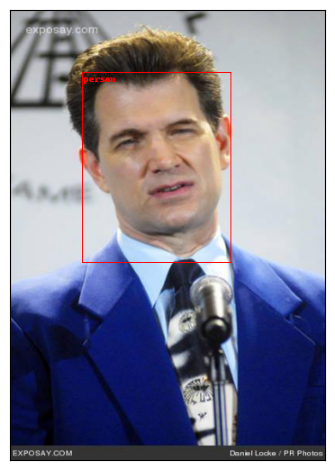

In [ ]:
show_preds(ds_celeba_train[4])

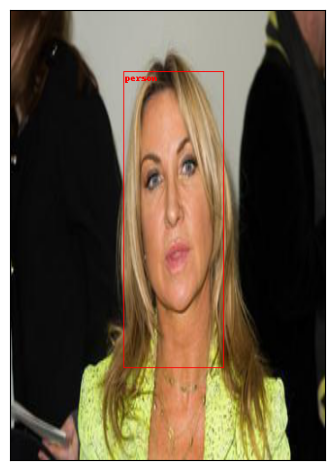

In [ ]:
show_preds(ds_celeba_val[4])

### ONE CHECK FORWARD METHOD

In [ ]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1').to(DEVICE)
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='COCO_V1').to(DEVICE)
# model = torchvision.models.detection.retinanet_resnet50_fpn(weights='COCO_V1').to(DEVICE)

In [ ]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# model

In [ ]:
batch_size = 8

data_loader = torch.utils.data.DataLoader(ds_celeba_train, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          # collate_fn=collate_fn
                                          )

data_loader_val = torch.utils.data.DataLoader(ds_celeba_val, batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          # collate_fn=collate_fn
                                          )

In [ ]:
# For Training
model = model.to(DEVICE)
images, targets = next(iter(data_loader))
images = images.to(DEVICE)
images = [image for image in images]
targets = [{'boxes': b.to(DEVICE), 'labels': l.to(DEVICE), 'image_id': i.to(DEVICE), 'iscrowd': c.to(DEVICE), 'area': a.to(DEVICE)}
           for b, l, i, c, a in zip(targets['boxes'], targets['labels'], targets['image_id'], targets['iscrowd'], targets['area'])]
output = model(images,targets)   # Returns losses and detections

In [ ]:
# For inference
model.eval()
images, targets = next(iter(data_loader))
images = images.to(DEVICE)
images = [image for image in images]
# выключаем расчет градиентов
with torch.no_grad():
    predictions = model(images)  # Returns predictions

In [ ]:
CONF_THRESH = .6

for i in range(batch_size):
  show_preds(images[i], predictions[i], CONF_THRESH)

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 344214, done.
remote: Counting objects: 100% (79313/79313), done.
remote: Compressing objects: 100% (1540/1540), done.
remote: Total 344214 (delta 78315), reused 78589 (delta 77730), pack-reused 264901
Receiving objects: 100% (344214/344214), 691.61 MiB | 4.24 MiB/s, done.
Resolving deltas: 100% (317294/317294), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
# IN ENGINE.PY:
# replace: targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
# to: targets = [{'boxes': b.to(device), 'labels': l.to(device), 'image_id': i.to(device), 'iscrowd': c.to(device), 'area': a.to(device)}
#                   for b, l, i, c, a in zip(targets['boxes'], targets['labels'], targets['image_id'], targets['iscrowd'], targets['area'])]

# after: for images, targets in metric_logger.log_every(data_loader, 100, header):
#            images = list(img.to(device) for img in images)

# add: targets = [{'boxes': b.to(device), 'labels': l.to(device), 'image_id': i.to(device), 'iscrowd': c.to(device), 'area': a.to(device)}
#                   for b, l, i, c, a in zip(targets['boxes'], targets['labels'], targets['image_id'], targets['iscrowd'], targets['area'])]


# IN COCO_EVAL.PY:
# delete: import torch.__six

# replace: torch._six.string_classes
# to: str

# MORE: https://github.com/pytorch/pytorch/pull/94709

In [ ]:
from engine import train_one_epoch, evaluate
from torch.optim.lr_scheduler import StepLR

### MODEL TRAINING

In [ ]:
batch_size = 8
data_loader = torch.utils.data.DataLoader(ds_celeba_train, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          )

data_loader_val = torch.utils.data.DataLoader(ds_celeba_val, batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          )

In [ ]:
# move model to the right device
model.to(DEVICE)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 1 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=1,
                                               gamma=0.1)

In [ ]:
# let's train it for 3 epochs
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 50 iterations
    train_one_epoch(model, optimizer, data_loader, DEVICE, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_val, device=DEVICE)
    torch.save(model.state_dict(), f'/content/drive/MyDrive/fasterrcnn_resnet50_fpn_fine_t_all_{epoch}.pth')

### CHECK RESULT

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/fasterrcnn_resnet50_fpn_fine_t_all_2.pth'))

<All keys matched successfully>

In [ ]:
test_image_names = sorted(os.listdir(TEST_PATH / Path("0_30k")))
test_image_names[:3]

['000003.jpg', '000004.jpg', '000006.jpg']

In [ ]:
test_bboxes = []
for i in test_image_names:
  test_bboxes.append(all_bboxes[:, 1:][np.where(all_bboxes[:, 0] == i)].reshape(-1).tolist())
test_bboxes[:3]

[[216, 59, 307, 185], [622, 257, 1186, 1038], [146, 67, 328, 319]]

In [ ]:
ds_celeba_test = CreateDatasetBoxes(TEST_PATH, transform_images, test_bboxes, (500, 350))
ds_celeba_test[0]

(tensor([[[ 0.1939,  0.5707,  0.5878,  ...,  2.2318,  2.2318,  1.6153],
          [ 0.1939,  0.5707,  0.5878,  ...,  2.2318,  2.2318,  1.6153],
          [ 0.1768,  0.5536,  0.5707,  ...,  2.2318,  2.2318,  1.6153],
          ...,
          [-0.6109, -0.3712, -0.5082,  ..., -0.8678, -0.8849, -0.9705],
          [-0.6623, -0.4397, -0.5596,  ..., -0.8164, -0.8335, -0.9534],
          [-0.6965, -0.4911, -0.5938,  ..., -0.7822, -0.8164, -0.9363]],
 
         [[ 0.2752,  0.6779,  0.7304,  ...,  2.4111,  2.4111,  1.7808],
          [ 0.2752,  0.6779,  0.7304,  ...,  2.4111,  2.4111,  1.7808],
          [ 0.2577,  0.6779,  0.7129,  ...,  2.4111,  2.4111,  1.7808],
          ...,
          [-0.4776, -0.2325, -0.3725,  ..., -0.7577, -0.7752, -0.8627],
          [-0.5301, -0.3025, -0.4251,  ..., -0.7052, -0.7227, -0.8452],
          [-0.5651, -0.3550, -0.4601,  ..., -0.6702, -0.7052, -0.8277]],
 
         [[ 0.3916,  0.7576,  0.7402,  ...,  2.6226,  2.6226,  1.9951],
          [ 0.3916,  0.7576,

In [ ]:
batch_size = 10

data_loader_test = torch.utils.data.DataLoader(ds_celeba_test, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          )

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# For inference
model = model.to(DEVICE)
model.eval()
images, targets = next(iter(data_loader_test))
images = images.to(DEVICE)
images = [image for image in images]
# выключаем расчет градиентов
with torch.no_grad():
    predictions = model(images)  # Returns predictions

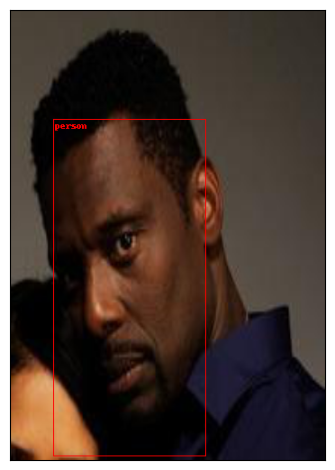

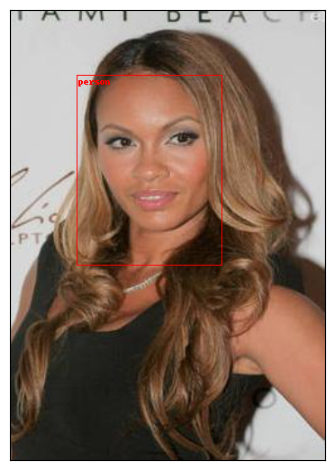

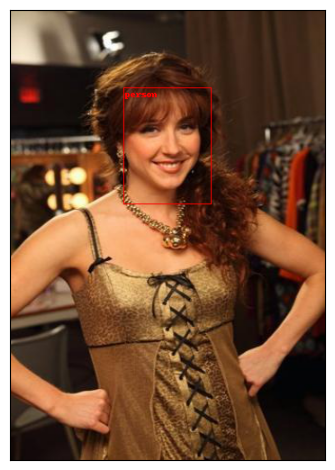

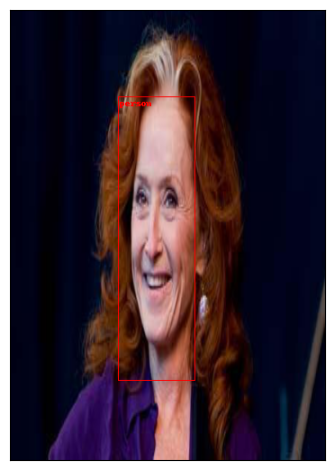

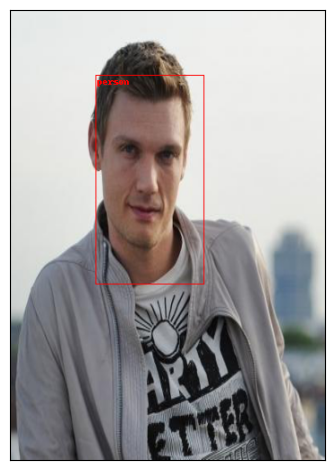

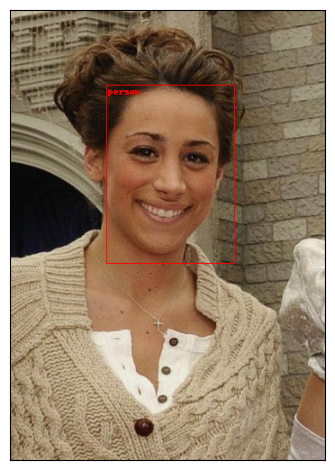

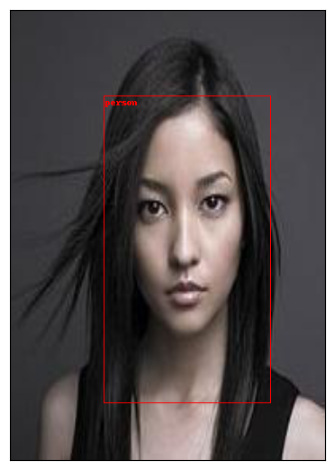

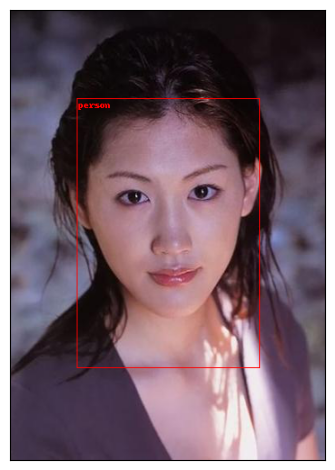

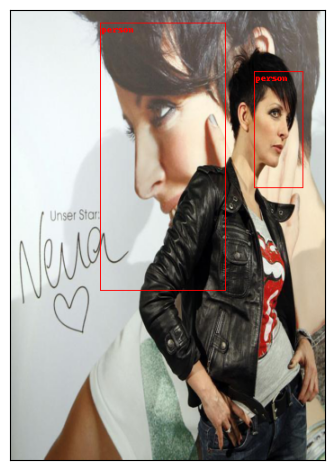

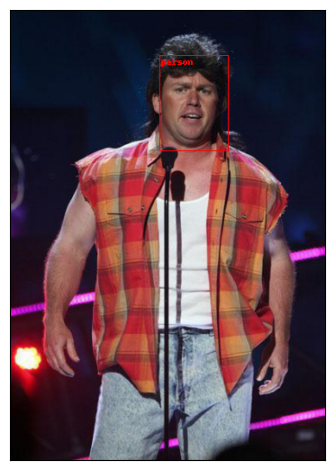

In [ ]:
CONF_THRESH = .6

for i in range(batch_size):
  show_preds(images[i], predictions[i], CONF_THRESH)

### FREEZE BACKBONE

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
params

[]

In [ ]:
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
params

[Parameter containing:
 tensor([[-0.0011,  0.0229, -0.0173,  ...,  0.0021, -0.0008,  0.0175],
         [-0.0091, -0.0077, -0.0092,  ...,  0.0187, -0.0253,  0.0107]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0240, -0.0187], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.0125, -0.0234, -0.0087,  ...,  0.0253, -0.0079,  0.0210],
         [ 0.0219,  0.0040, -0.0135,  ..., -0.0112,  0.0289,  0.0115],
         [-0.0054,  0.0067, -0.0074,  ..., -0.0215,  0.0051,  0.0096],
         ...,
         [-0.0053, -0.0204,  0.0353,  ..., -0.0184,  0.0051, -0.0037],
         [ 0.0190,  0.0076, -0.0252,  ...,  0.0122, -0.0062,  0.0025],
         [-0.0156, -0.0088, -0.0123,  ..., -0.0130,  0.0207,  0.0122]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0063, -0.0147,  0.0077,  0.0016,  0.0127, -0.0013, -0.0119, -0.0027],
        device='cuda:0', requires_grad=True)]

In [ ]:
optimizer = torch.optim.Adam(params, lr=1e-4)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 1 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 50 iterations
    train_one_epoch(model, optimizer, data_loader, DEVICE, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_val, device=DEVICE)
    torch.save(model.state_dict(), f'/content/drive/MyDrive/fasterrcnn_resnet50_pretrained_fine_t_head_{epoch}.pth')

### Сonclusions
1. Fine tunning с расчетом градиентов по всем слоям на большом датасете (30 k) дает лучший результат Loss (avg~ <0.02), но занимает много времени. Мощности Colab хватает только на одну полную эпоху.
2. Fine tunning с расчетом градиентов по всем слоям на малом датасете (12 k) дает приемлимый результат Loss (avg~ <0.035), мощности Colab хватает на несколько эпох (2-3).
3. Дообучение модели с замороженными слоями кроме head, дает крайне несущественный прирост в снижении Loss (avg~ 0.032), выполняется крайне быстро, мощности хватает до 5 эпох.
4. Feature extractor с замороженными слоями кроме head без предобучения  на целевой выборке показал худший и очень низкий результат Loss (avg~ 0.25) при высокой скорости, до 5 эпох.

<a href='https://colab.research.google.com/drive/1ND-gsUwdqm9_Grm6e8Iq0LbLJhMhnpZC'>notebook copy</a>